<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#20-news-groups-load" data-toc-modified-id="20-news-groups-load-1">20 news groups load</a></span></li><li><span><a href="#Spectral-Clustering" data-toc-modified-id="Spectral-Clustering-2">Spectral Clustering</a></span></li><li><span><a href="#PCA" data-toc-modified-id="PCA-3">PCA</a></span></li><li><span><a href="#SPECTRAL" data-toc-modified-id="SPECTRAL-4">SPECTRAL</a></span></li><li><span><a href="#SPECTRAL-V2" data-toc-modified-id="SPECTRAL-V2-5">SPECTRAL V2</a></span></li></ul></div>

# 20 news groups load

In [1]:
from sklearn import metrics
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [2]:
all_news = fetch_20newsgroups(subset='all')
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.5, sublinear_tf=True, max_features=100)

In [3]:
news_data = vectorizer.fit_transform(all_news.data)
news_target = all_news.target
news_target_names = all_news.target_names 

feature_names = vectorizer.get_feature_names()

In [4]:
news_data.shape, news_target.shape

((18846, 100), (18846,))

In [5]:
news_target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [6]:
mask = (news_target == 0) | (news_target == 1)

In [7]:
set(news_target)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}

# Spectral Clustering

In [8]:
import spectral
import scipy
from scipy import sparse
import numpy as np
import networkx as nx

from sklearn import preprocessing, decomposition, model_selection

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
sns.set(rc={"figure.figsize": (15, 6)})
sns.set_palette(sns.color_palette("Set2", 10))

In [9]:
features = scipy.sparse.csr_matrix.todense(news_data)[mask]

In [10]:
distances = spectral.features_to_dist_matrix(features)

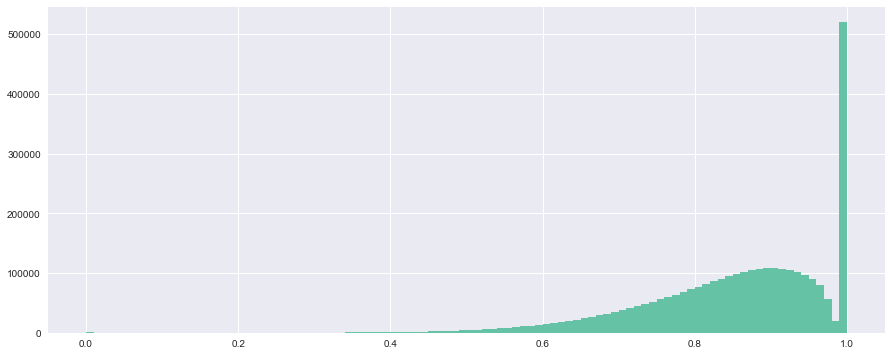

In [11]:
plt.hist(distances.flatten(), bins=100);

In [12]:
print('{} distances equal exactly zero.'.format(np.sum(distances == 0)))

1782 distances equal exactly zero.


In [13]:
all_weights = spectral.dist_to_adj_matrix(distances, 'gaussian')

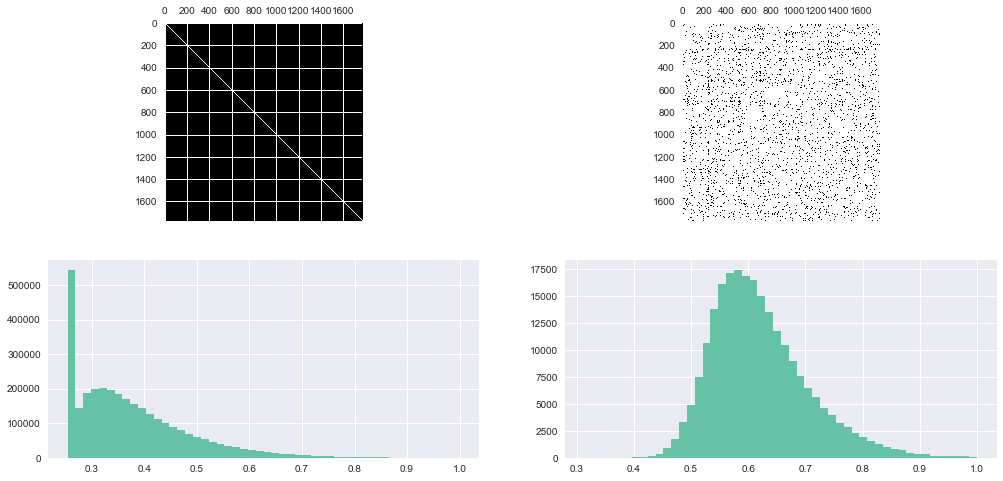

In [14]:
fix, axes = plt.subplots(2, 2, figsize=(17, 8))
def plot(weights, axes):
    axes[0].spy(weights)
    axes[1].hist(weights[weights > 0].reshape(-1), bins=50);

NEIGHBORS = 100
weights = spectral.filter_neighbors(all_weights, NEIGHBORS)

plot(all_weights, axes[:, 0])
plot(weights, axes[:, 1])

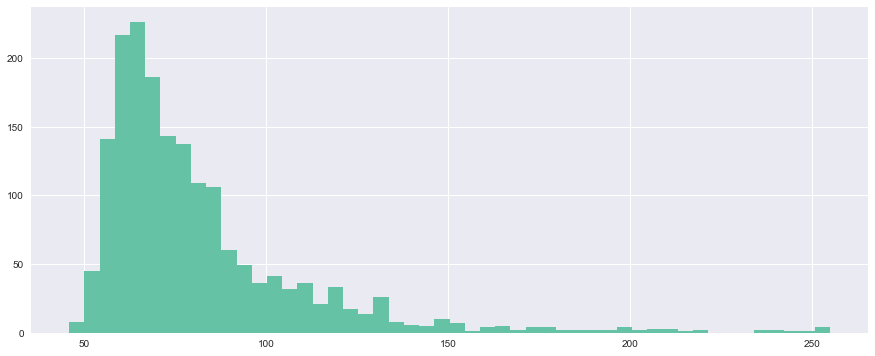

In [15]:
# Weighted degree distribution
degrees = np.sum(weights, axis=0)

plt.hist(degrees, bins=50);

In [16]:
D = np.diag(degrees)
W = weights
L = D - W

inv_sqrt_D = np.diag(1 / np.diag(D**(0.5)))

normalized_laplacian = inv_sqrt_D @ L @ inv_sqrt_D

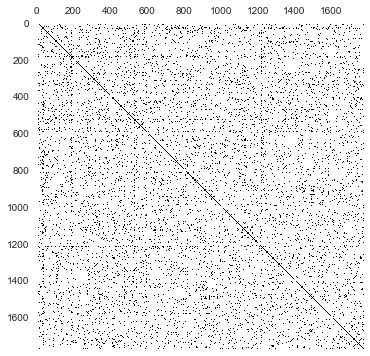

In [17]:
plt.spy(normalized_laplacian);

In [18]:
eigenvalues, eigenvectors = sparse.linalg.eigsh(normalized_laplacian, k=10, which='SM') # which='SA' gives us similar results

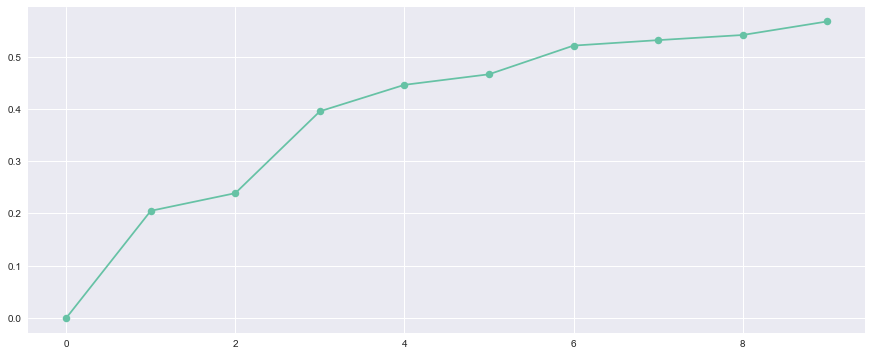

In [19]:
plt.plot(eigenvalues, '.-', markersize=15);

In [20]:
G = nx.from_numpy_matrix(L)
gc = max(nx.connected_component_subgraphs(G), key=len)

In [152]:
assert len(gc.nodes()) == weights.shape[0], "GCC should contain all nodes"

# PCA

In [22]:
features_pca = decomposition.PCA(n_components=2).fit_transform(features)

In [93]:
labels = news_target[mask] == 0

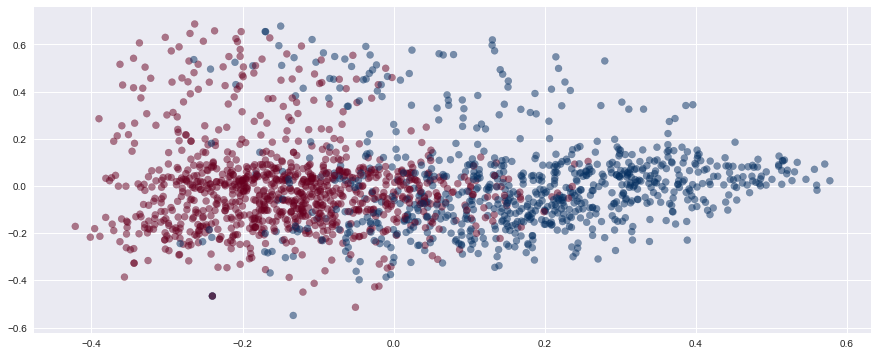

In [153]:
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=labels, cmap='RdBu', alpha=0.5);

# SPECTRAL

331 errors (18.68%)


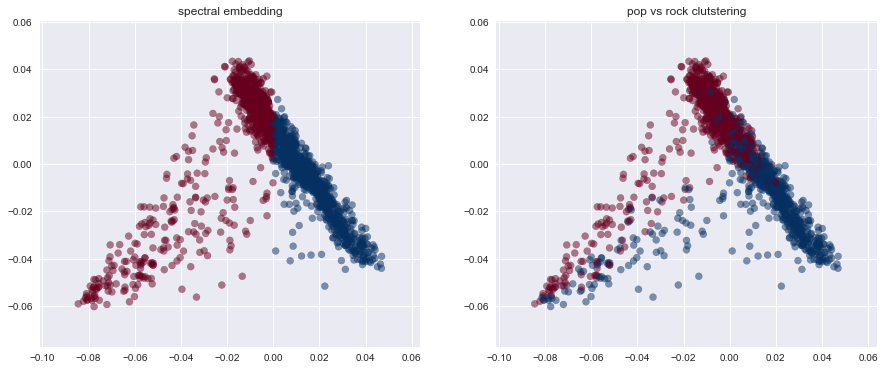

In [154]:
spectral.compare_plot_labels(eigenvectors, labels)

# SPECTRAL V2

In [133]:
unsupervised_labels = (eigenvectors[:, 1] - eigenvectors[:, 2]) > 0

In [151]:
accuracy = spectral.compute_err(labels, unsupervised_labels)

print('accuracy of {}%'.format(int(accuracy * 100)))

accuracy of 14%


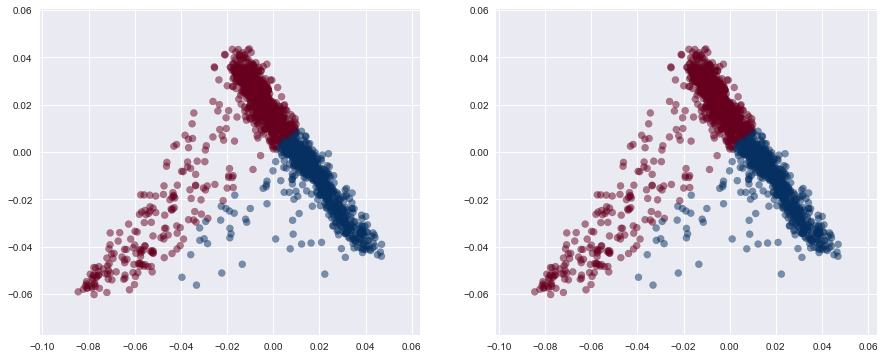

In [136]:
f, axes = plt.subplots(nrows=1, ncols=2)

for ax, lab in zip(axes.flatten(), [unsupervised_labels, labels]):
    spectral.plot_labels(eigenvectors, unsupervised_labels, ax=ax)